In [1]:
import numpy as np

import pandas as pd

import xarray as xr

import glob

import matplotlib as mpl

import matplotlib.pyplot as plt

import math as mt

from math import e

import datetime

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from random import seed
from random import randint

from scipy.signal import hilbert
import statistics
from scipy.stats import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Read IPSL files

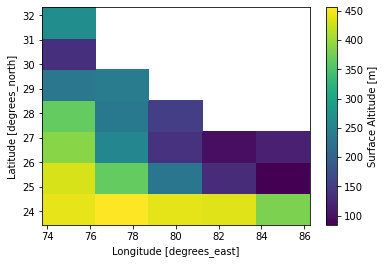

In [3]:
#Read Orography
I_OroData = xr.open_dataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc')
Ioro=I_OroData.orog.sel(lat=slice(24,32),lon=slice(74,86))
#Ioro.plot()
#Create Mask
Ioro.values[Ioro.values>500.1]=np.NaN
Imask=Ioro.values/Ioro.values
Ioro.plot()

# GFDL T2m and T2m hilbert

In [5]:
#Read Data
I_t2mData= xr.open_dataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/tas_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
#time1=I_t2mData.indexes['time'].to_datetimeindex()
#I_t2mData=I_t2mData.assign_coords(time=("time", time1))
It2mD = I_t2mData.sel(lat=slice(24,32),lon=slice(74,86))

In [6]:

#Mask data
It2mD.tas.values=It2mD.tas.values*Imask
# area avg
It2mTS=It2mD.mean(dim=['lat','lon'], skipna=True).tas
#Hilbert transform
It2m_hb = np.imag(hilbert(It2mTS.values,axis=0))
It2m_hb_ds = xr.Dataset({'It2m_hb': (('time'), It2m_hb)}, coords={'time': It2mTS.time})
#ISelect only Dec Jan months
It2m=It2mTS[((It2mTS.time.dt.month>11) | (It2mTS.time.dt.month<2))]
It2mhb=It2m_hb_ds.It2m_hb[((It2m_hb_ds.time.dt.month>11) | (It2m_hb_ds.time.dt.month<2))] 


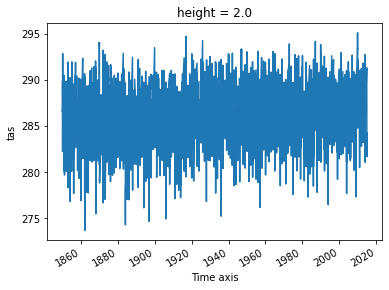

In [7]:
It2m.plot()

# IPSL wind speed and wind speed hilbert

In [8]:
# Read data
Iu10Data = xr.open_dataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/uas_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
Iv10Data = xr.open_dataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/vas_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
#Iu10Data=Iu10Data.assign_coords(time=("time", time1))
#Iv10Data=Iv10Data.assign_coords(time=("time", time1))

Iu10D = Iu10Data.sel(lat=slice(24,32),lon=slice(74,86))
Iv10D = Iv10Data.sel(lat=slice(24,32),lon=slice(74,86))
# Calculate wind speed
Iws = ((Iv10D.vas.values**2)+(Iu10D.uas.values**2))**0.5
Iws_ds = xr.Dataset({'Iws': (('time','lat','lon'), Iws)}, coords={'time': Iv10D.time,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Mask
Iws_ds.Iws.values=Iws_ds.Iws.values*Imask
# area avg
IwsTS=Iws_ds.mean(dim=['lat','lon'], skipna=True).Iws
# hilbert
Iws_hb = np.imag(hilbert(IwsTS.values,axis=0))
Iws_hb_ds = xr.Dataset({'Iws_hb': (('time'), Iws_hb)}, coords={'time': IwsTS.time})
#Select Dec and Jan
Iws=IwsTS[((IwsTS.time.dt.month>11) | (IwsTS.time.dt.month<2))] 
Iwshb=Iws_hb_ds.Iws_hb[((Iws_hb_ds.time.dt.month>11) | (Iws_hb_ds.time.dt.month<2))]

# IPSL rh and rh hilbert

In [10]:
#Read Data
I_rhData= xr.open_mfdataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/hurs_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
#I_rhData=I_rhData.assign_coords(time=("time", time1))

IrhD = I_rhData.sel(lat=slice(24,32),lon=slice(74,86))
IrhD.hurs.values=IrhD.hurs.values/100.0
#Mask data
IrhD.hurs.values=IrhD.hurs.values*Imask
# area avg
IrhTS=IrhD.mean(dim=['lat','lon'], skipna=True).hurs
#Hilbert transform
Irh_hb = np.imag(hilbert(IrhTS.values,axis=0))
Irh_hb_ds = xr.Dataset({'Irh_hb': (('time'), Irh_hb)}, coords={'time': IrhTS.time})
#ISelect only Dec Jan months
Irh=IrhTS[((IrhTS.time.dt.month>11) | (IrhTS.time.dt.month<2))]
Irhhb=Irh_hb_ds.Irh_hb[((Irh_hb_ds.time.dt.month>11) | (Irh_hb_ds.time.dt.month<2))] 


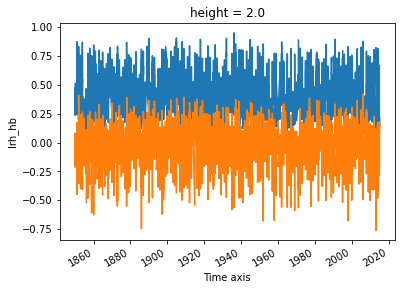

In [11]:
Irh.plot()
Irhhb.plot()

#  IPSL inv and inv hilbert

In [12]:
# Read 850 hPa t
I_tLevData= xr.open_dataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
#I_tLevData=I_tLevData.assign_coords(time=("time", time1))

It850D=I_tLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
It850D.ta.values=It850D.ta.values*Imask
# Calculate inv
Iinv = It2mD.tas.values-It850D.ta.values
Iinv_ds = xr.Dataset({'Iinv': (('time','lat','lon'), Iinv)}, coords={'time': Iv10D.time,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Iinv_ds.Iinv
#Mask
Iinv_ds.Iinv.values=Iinv_ds.Iinv.values*Imask
# area avg
IinvTS=Iinv_ds.mean(dim=['lat','lon'], skipna=True).Iinv
# hilbert
Iinv_hb = np.imag(hilbert(IinvTS.values,axis=0))
Iinv_hb_ds = xr.Dataset({'Iinv_hb': (('time'), Iinv_hb)}, coords={'time': IinvTS.time})
#Select Dec and Jan
Iinv=IinvTS[((IinvTS.time.dt.month>11) | (IinvTS.time.dt.month<2))] 
Iinvhb=Iinv_hb_ds.Iinv_hb[((Iinv_hb_ds.time.dt.month>11) | (Iinv_hb_ds.time.dt.month<2))]



In [13]:
I_tLevData

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 143, lon: 144, plev: 8, time: 19840)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
  * plev       (plev) float32 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    ta         (time, plev, lat, lon) float32 ...
Attributes:
    CDI:                    Climate Data Interface version 1.9.5 (http://mpim...
    history:                Thu Jan 28 15:38:49 2021: cdo selmon,1,2,11,12 ta...
    source:                 IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; 144...
    institution:            Institut Pierre Simon Laplace, Paris 75252, France
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-07-11T07:27:16Z
    tracking_id:            hdl:21.14100/23b5d52f-1539-402d-8e15-189e0704062e
    description:            CMIP6 historical
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    activity_id:            CMIP
    contact:                ipsl-cmip6@listes.ipsl.fr
    data_specs_version:     01.00.21
    dr2xml_version:         1.11
    experiment_id:          historical
    experiment:             all-forcing simulation of the recent past
    external_variables:     areacella
    forcing_index:          1
    frequency:              day
    grid:                   LMDZ grid
    grid_label:             gr
    nominal_resolution:     250 km
    initialization_index:   1
    institution_id:         IPSL
    license:                CMIP6 model data produced by IPSL is licensed und...
    mip_era:                CMIP6
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_activity_id:     CMIP
    parent_source_id:       IPSL-CM6A-LR
    parent_time_units:      days since 1850-01-01 00:00:00
    branch_method:          standard
    branch_time_in_parent:  21914.0
    branch_time_in_child:   0.0
    physics_index:          1
    product:                model-output
    realm:                  atmos
    source_id:              IPSL-CM6A-LR
    source_type:            AOGCM BGC
    sub_experiment_id:      none
    sub_experiment:         none
    table_id:               day
    variable_id:            ta
    EXPID:                  historical
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:          f1e40c1fc5d8281f865f72fbf4e38f9d
    model_version:          6.1.5
    parent_variant_label:   r1i1p1f1
    name:                   /ccc/work/cont003/gencmip6/p86caub/IGCM_OUT/IPSLC...
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.IPSL.IPSL-CM...
    variant_label:          r1i1p1f1
    realization_index:      1
    NCO:                    "4.6.0"
    CDO:                    Climate Data Operators version 1.9.5 (http://mpim...


# IPSL w700 and w700 hilbert

In [15]:
# Read Data
I_w700Data= xr.open_dataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/wap_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
#I_w700Data=I_w700Data.assign_coords(time=("time", time1))

Iw700D = I_w700Data.sel(lat=slice(24,32),lon=slice(74,86),plev=(70000))
#Mask data
Iw700D.wap.values=Iw700D.wap.values*Imask
# area avg
Iw700TS=Iw700D.mean(dim=['lat','lon'], skipna=True).wap
#Hilbert transform
Iw700_hb = np.imag(hilbert(Iw700TS.values,axis=0))
Iw700_hb_ds = xr.Dataset({'Iw700_hb': (('time'), Iw700_hb)}, coords={'time': Iw700TS.time})
#ISelect only Dec Jan months
Iw700=Iw700TS[((Iw700TS.time.dt.month>11) | (Iw700TS.time.dt.month<2))]
Iw700hb=Iw700_hb_ds.Iw700_hb[((Iw700_hb_ds.time.dt.month>11) | (Iw700_hb_ds.time.dt.month<2))] 

# GFDL ushear and ushear hilbert

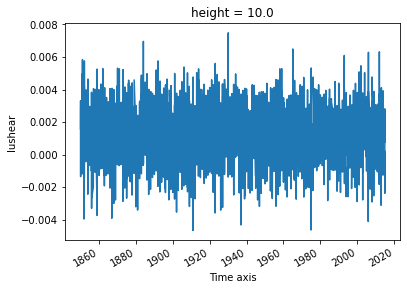

In [16]:
# Read 850 hPa u 
I_uLevData= xr.open_dataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/ua_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
#I_uLevData=I_uLevData.assign_coords(time=("time", time1))

Iu850D=I_uLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
# Read 850 hPa  z 
I_zLevData= xr.open_dataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/zg_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
#I_zLevData=I_zLevData.assign_coords(time=("time", time1))

Iz850D=I_zLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
# Calculate ushear
Iushear = (Iu850D.ua.values-Iu10D.uas.values)/(Iz850D.zg.values) 
Iushear_ds = xr.Dataset({'Iushear': (('time','lat','lon'), Iushear)}, coords={'time': Iv10D.time,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Iushear_ds.Iushear[0,:,:].plot()
#Mask
Iushear_ds.Iushear.values=Iushear_ds.Iushear.values*Imask
# area avg
IushearTS=Iushear_ds.mean(dim=['lat','lon'], skipna=True).Iushear
# hilbert
Iushear_hb = np.imag(hilbert(IushearTS.values,axis=0))
Iushear_hb_ds = xr.Dataset({'Iushear_hb': (('time'), Iushear_hb)}, coords={'time': IushearTS.time})
#Select Dec and Jan
Iushear=IushearTS[((IushearTS.time.dt.month>11) | (IushearTS.time.dt.month<2))] 
Iushearhb=Iushear_hb_ds.Iushear_hb[((Iushear_hb_ds.time.dt.month>11) | (Iushear_hb_ds.time.dt.month<2))]
Iushear.plot()

In [17]:
#IX       = pd.DataFrame([It2m.values,Iws.values,Irh.values,Iinv.values,Iw700.values,Iushear.values*100.0,
#                       It2mhb.values,Iwshb.values,Irhhb.values,Iinvhb.values,Iw700hb.values,Iushearhb.values]).T[:]
IX       = pd.DataFrame([It2m.values,Iws.values,Irh.values,Iinv.values,Iw700.values,Iushear.values*100.0]).T[:]



IX.index = pd.to_datetime(It2m.indexes['time'].values)
IX

,0,1,2,3,4,5
1850-01-01 12:00:00,286.710388,2.463207,0.291392,2.043589,0.222726,0.157800
1850-01-02 12:00:00,286.534271,2.147102,0.267103,-0.606641,0.221220,0.204388
1850-01-03 12:00:00,287.478516,1.754743,0.324038,0.443339,0.068820,0.172856
1850-01-04 12:00:00,287.815735,1.713766,0.344938,2.903497,0.041865,0.158226
1850-01-05 12:00:00,287.242157,1.992131,0.334265,2.983176,0.107179,0.150724
...,...,...,...,...,...,...
2014-12-27 12:00:00,284.062775,2.655996,0.153738,3.441725,0.128812,0.239227
2014-12-28 12:00:00,281.807648,2.984681,0.134395,1.171609,0.168088,0.272702
2014-12-29 12:00:00,281.694519,2.184486,0.149795,-0.327626,0.119483,0.234043
2014-12-30 12:00:00,282.672882,1.636736,0.162892,0.792093,0.091127,0.170989


In [18]:
normI = StandardScaler().fit(IX)
    # transform training data
IX = normI.transform(IX)
IX

array([[ 0.23938621,  0.74960788, -0.5138044 , -1.49703965,  1.60782752,
         0.21501508],
       [ 0.17926125,  0.28148344, -0.66724045, -3.00437223,  1.59447582,
         0.5484766 ],
       [ 0.50161895, -0.29956548, -0.30757539, -2.40719071,  0.24350786,
         0.32278098],
       ...,
       [-1.47299255,  0.33684522, -1.4082826 , -2.8456808 ,  0.69262008,
         0.76073995],
       [-1.13898701, -0.47432487, -1.32554608, -2.20883447,  0.44125386,
         0.30941547],
       [-0.61153143, -0.7778024 , -1.36343029, -1.59659731, -0.16304315,
        -0.36558552]])

In [57]:
reg = load('regGB_Obs.joblib') 
reg

GradientBoostingRegressor(learning_rate=0.04, min_samples_leaf=20,
                          n_estimators=300, random_state=0)

In [58]:
regLin=load('regLR_Obs.joblib')
regLin

LinearRegression()

In [59]:
y_ds=load('y_ds_Obs.joblib')
y_ds

<xarray.Dataset>
Dimensions:  (time: 2170)
Coordinates:
    expver   float64 1.0
  * time     (time) datetime64[ns] 1980-01-01T10:30:00 ... 2014-12-31T10:30:00
Data variables:
    y        (time) float64 0.32 0.4 0.4 0.36 0.32 ... 0.68 0.8 0.76 0.72 0.76

In [60]:
y_pred_ds=load('y_pred_ds_Obs.joblib')
y_pred_ds

<xarray.Dataset>
Dimensions:  (time: 2170)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31
Data variables:
    y_pred   (time) float64 0.2012 0.2858 0.3558 0.3774 ... 0.6405 0.6206 0.6037

In [61]:
y_predLin_ds=load('y_predLin_ds_Obs.joblib')
y_predLin_ds

<xarray.Dataset>
Dimensions:    (time: 2170)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31
Data variables:
    y_predLin  (time) float64 0.2822 0.383 0.3899 ... 0.5674 0.5565 0.4545

In [62]:
Iy_pred=reg.predict(IX)
Iy_predLin=regLin.predict(IX)
Iy_df = pd.DataFrame(Iy_pred)
Iy_df.index = pd.to_datetime(It2m.indexes['time'].values)
Iy_dfLin = pd.DataFrame(Iy_predLin)
Iy_dfLin.index = pd.to_datetime(It2m.indexes['time'].values)

In [63]:
Iy_ds=xr.Dataset({'Iy_pred': (('time'), Iy_pred)}, coords={'time': It2m.time})
Iy_ds

IyLin_ds=xr.Dataset({'Iy_predLin': (('time'), Iy_predLin)}, coords={'time': It2m.time})
IyLin_ds

<xarray.Dataset>
Dimensions:     (time: 10230)
Coordinates:
    height      float64 2.0
  * time        (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:0...
Data variables:
    Iy_predLin  (time) float64 0.3172 0.3947 0.372 ... 0.3039 0.2901 0.218

(0.816141217070912, 0.0)

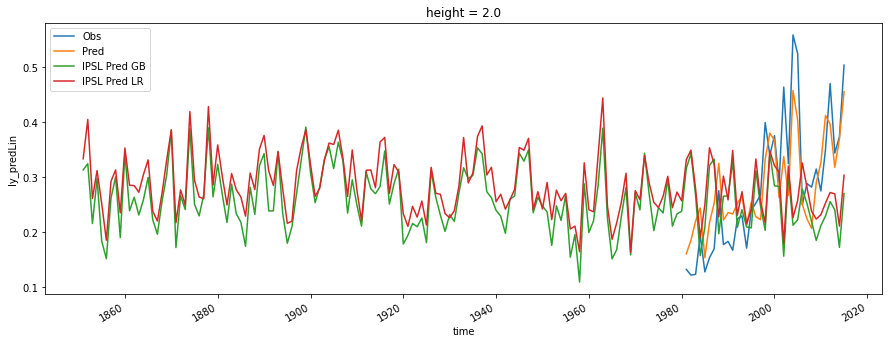

In [64]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.dropna(dim='time').plot(label='Pred')


Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time').plot(label='IPSL Pred GB')
IyLin_ds.resample(time='1Y').mean().Iy_predLin.dropna(dim='time').plot(label='IPSL Pred LR')

plt.legend()
np.corrcoef(y_ds.y.values, y_pred_ds.y_pred.values)
stats.pearsonr(y_ds.y.values, y_pred_ds.y_pred.values)
#y_ds.y.values.corr(y_pred_ds.y_pred.values)

(0.816141217070912, 0.0)

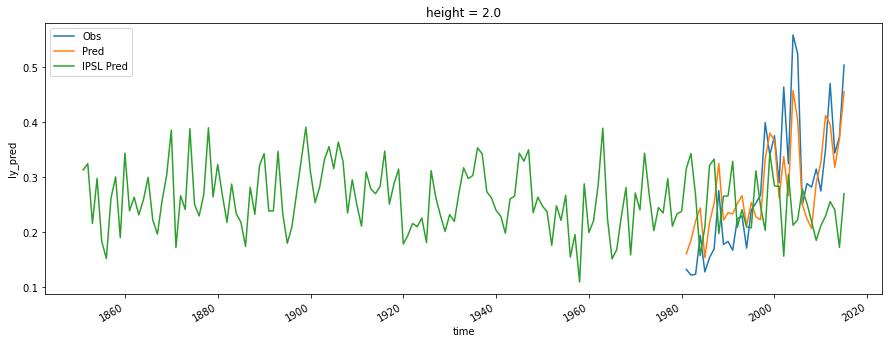

In [65]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.dropna(dim='time').plot(label='Pred')
Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time').plot(label='IPSL Pred')


plt.legend()
np.corrcoef(y_ds.y.values, y_pred_ds.y_pred.values)
stats.pearsonr(y_ds.y.values, y_pred_ds.y_pred.values)

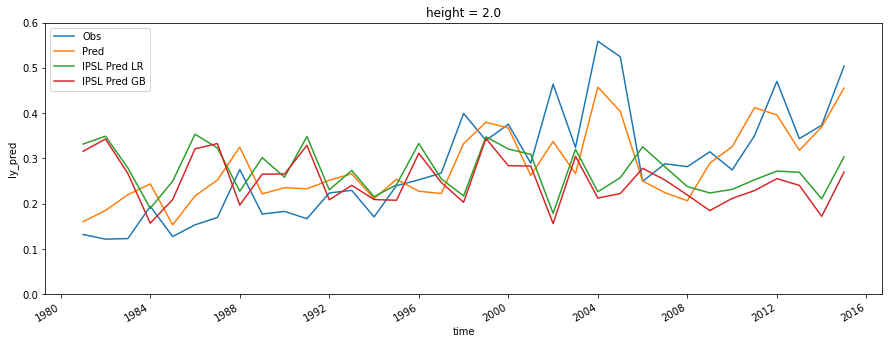

In [67]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.dropna(dim='time').plot(label='Pred')
IyLin_ds.resample(time='1Y').mean().Iy_predLin.dropna(dim='time')[130:].plot(label='IPSL Pred LR')
Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time')[130:].plot(label='IPSL Pred GB')
plt.ylim(0, 0.6)
plt.legend()
plt.savefig('../IPSL_yearly.jpeg',dpi=300)

In [89]:
Widespread_Iy_pred=Iy_ds.Iy_pred.where(Iy_ds.Iy_pred > 0.44, drop=True)
# Total number of widespread fog days
print(Widespread_Iy_pred.sel(time=slice('1980-1-1','2014-12-31')).count())
# mean annual frequency
print(Iy_ds.Iy_pred.sel(time=slice('1980-1-1','2014-12-31')).where(Iy_ds.Iy_pred > 0.44).resample(time='1Y').count().mean())
# interannual std 
print(Iy_ds.Iy_pred.sel(time=slice('1980-1-1','2014-12-31')).where(Iy_ds.Iy_pred > 0.44).resample(time='1Y').count().std())
#Widespread_y_pred.resample(time='1Y').count()

<xarray.DataArray 'Iy_pred' ()>
array(240)
Coordinates:
    height   float64 2.0
<xarray.DataArray 'Iy_pred' ()>
array(6.85714286)
Coordinates:
    height   float64 2.0
<xarray.DataArray 'Iy_pred' ()>
array(5.78245058)
Coordinates:
    height   float64 2.0


In [90]:
Widespread_Iy_predLin=IyLin_ds.Iy_predLin.where(IyLin_ds.Iy_predLin > 0.44, drop=True)
# Total number of widespread fog days
print(Widespread_Iy_predLin.sel(time=slice('1980-1-1','2014-12-31')).count())
# mean annual frequency
print(IyLin_ds.Iy_predLin.sel(time=slice('1980-1-1','2014-12-31')).where(IyLin_ds.Iy_predLin > 0.44).resample(time='1Y').count().mean())
# interannual std 
print(IyLin_ds.Iy_predLin.sel(time=slice('1980-1-1','2014-12-31')).where(IyLin_ds.Iy_predLin > 0.44).resample(time='1Y').count().std())
#Widespread_y_pred.resample(time='1Y').count()

<xarray.DataArray 'Iy_predLin' ()>
array(279)
Coordinates:
    height   float64 2.0
<xarray.DataArray 'Iy_predLin' ()>
array(7.97142857)
Coordinates:
    height   float64 2.0
<xarray.DataArray 'Iy_predLin' ()>
array(6.57043471)
Coordinates:
    height   float64 2.0


In [68]:
print(np.corrcoef(y_ds.resample(time='1Y').mean().y,Iy_ds.resample(time='1Y').mean().Iy_pred[130:]))
print(np.corrcoef(y_ds.resample(time='1Y').mean().y,IyLin_ds.resample(time='1Y').mean().Iy_predLin[130:]))

[[ 1.         -0.32655121]
 [-0.32655121  1.        ]]
[[ 1.         -0.30223245]
 [-0.30223245  1.        ]]


obsTs=y_ds.resample(time='1M').mean().y.dropna(dim='time')
time1=obsTs["time"].dt.strftime("%m-%Y")
obsTs1=obsTs.assign_coords(time=("time", time1))


GBTs=Iy_ds.resample(time='1M').mean().Iy_pred.dropna(dim='time')[259:]
timeGB=GBTs["time"].dt.strftime("%m-%Y")
GBTs1=GBTs.assign_coords(time=("time", timeGB))
GBTs1

LinTs=IyLin_ds.resample(time='1M').mean().Iy_predLin.dropna(dim='time')[259:]
timeLin=LinTs["time"].dt.strftime("%m-%Y")
LinTs1=LinTs.assign_coords(time=("time", timeGB))
LinTs1



plt.figure(figsize=[15,5])
plt.plot(obsTs1.time.values,obsTs1.values,label='Obs')
plt.plot(GBTs1.time.values,GBTs1.values,label='GB_GFDL')
plt.plot(LinTs1.time.values,LinTs1.values,label='LR_GFDL')
plt.xticks(rotation=90)
plt.legend() 
#y_ds1.y.plot()

obsTs=y_ds.resample(time='1Y').mean().y.dropna(dim='time')
time1=obsTs["time"].dt.strftime("%Y")
obsTs1=obsTs.assign_coords(time=("time", time1))


GBTs=Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time')[259:]
timeGB=GBTs["time"].dt.strftime("%Y")
GBTs1=GBTs.assign_coords(time=("time", timeGB))
GBTs1

LinTs=IyLin_ds.resample(time='1Y').mean().Iy_predLin.dropna(dim='time')[259:]
timeLin=LinTs["time"].dt.strftime("%Y")
LinTs1=LinTs.assign_coords(time=("time", timeGB))
LinTs1



plt.figure(figsize=[15,5])
plt.plot(obsTs1.time.values,obsTs1.values,label='Obs')
plt.plot(GBTs1.time.values,GBTs1.values,label='GB_GFDL')
plt.plot(LinTs1.time.values,LinTs1.values,label='LR_GFDL')
plt.xticks(rotation=90)
plt.legend() 
#y_ds1.y.plot()

In [31]:
# Read z500 data
Iz500Data_Orig = I_zLevData.sel(plev=50000)
#Iz500Data


# Calculate anomalies

In [32]:
climatology = Iz500Data_Orig.groupby("time.dayofyear").mean("time")
Iz500Data = Iz500Data_Orig.groupby("time.dayofyear") - climatology
#climatology
Iz500Data.time

<xarray.DataArray 'time' (time: 19840)>
array(['1850-01-01T12:00:00.000000000', '1850-01-02T12:00:00.000000000',
       '1850-01-03T12:00:00.000000000', ..., '2014-12-29T12:00:00.000000000',
       '2014-12-30T12:00:00.000000000', '2014-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
    plev       float32 5e+04
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Attributes:
    standard_name:  time
    long_name:      Time axis
    bounds:         time_bnds
    axis:           T

In [83]:
Iy_ds.Iy_pred
Widespread_Iy1=Iy_ds.Iy_pred.where(Iy_ds.Iy_pred > 0.44, drop=True)
Widespread_Iy=Widespread_Iy1.sel(time=slice('1980-1-1','2014-12-31'))
totalCnt=Widespread_Iy.time.sizes
totalCnt
Widespread_Iy

<xarray.DataArray 'Iy_pred' (time: 240)>
array([0.4749575 , 0.53799932, 0.55474905, 0.64627127, 0.63062366,
       0.45918055, 0.4533876 , 0.52456587, 0.4686553 , 0.56068959,
       0.57783708, 0.4763228 , 0.45702252, 0.47948399, 0.4907547 ,
       0.49851225, 0.46158719, 0.52907296, 0.56545006, 0.4504929 ,
       0.44566697, 0.51346268, 0.46580415, 0.56199458, 0.52971171,
       0.57610651, 0.45585662, 0.48097882, 0.47923449, 0.49615078,
       0.46765555, 0.47246321, 0.50014852, 0.48194362, 0.51236443,
       0.52503236, 0.62453958, 0.56773438, 0.57438071, 0.45029036,
       0.45115868, 0.47134264, 0.47717183, 0.51998128, 0.49916667,
       0.4600646 , 0.57926166, 0.63868279, 0.55118634, 0.59059703,
       0.56189342, 0.51318033, 0.44925369, 0.49860682, 0.57248937,
       0.54042343, 0.49979847, 0.45215675, 0.52891319, 0.53354738,
       0.56551223, 0.62292122, 0.46032957, 0.61821851, 0.53339716,
       0.52445918, 0.52181337, 0.46300524, 0.48914698, 0.67919232,
       0.6961644 , 0.63463289, 0.49620122, 0.46486842, 0.45904086,
       0.4417384 , 0.4646007 , 0.62461199, 0.57179119, 0.50400302,
       0.61178324, 0.62648149, 0.62127188, 0.58399292, 0.60731694,
       0.51503358, 0.466486  , 0.48285013, 0.44828287, 0.44212102,
       0.54431648, 0.44683892, 0.45023619, 0.50335484, 0.46399224,
       0.4858411 , 0.59535632, 0.50710197, 0.48323067, 0.52745537,
...
       0.56738274, 0.51055936, 0.49164622, 0.46972231, 0.48897656,
       0.48018519, 0.46168385, 0.54605845, 0.53699125, 0.52690811,
       0.51429895, 0.55423892, 0.44998746, 0.50628176, 0.61665117,
       0.64784321, 0.57895148, 0.47000854, 0.4908589 , 0.55226927,
       0.59071413, 0.53911679, 0.51098449, 0.45478195, 0.49036374,
       0.50899901, 0.5416928 , 0.47386006, 0.57543891, 0.53223307,
       0.4825512 , 0.60050924, 0.49909215, 0.51700264, 0.529347  ,
       0.485325  , 0.58406771, 0.44785372, 0.65424872, 0.66883569,
       0.49568648, 0.54338094, 0.6268726 , 0.56629308, 0.55281408,
       0.44254575, 0.4423971 , 0.45557827, 0.50724083, 0.47079337,
       0.49921758, 0.47681456, 0.49465061, 0.49427701, 0.47812285,
       0.51760563, 0.48422648, 0.50309701, 0.56751532, 0.58772304,
       0.51720204, 0.50585798, 0.53148279, 0.52718184, 0.5541349 ,
       0.53717041, 0.44770988, 0.49173941, 0.48243415, 0.53356462,
       0.57937441, 0.6174394 , 0.49532672, 0.57917898, 0.48501286,
       0.4949646 , 0.45344173, 0.46479398, 0.51375761, 0.45149099,
       0.46198587, 0.47354003, 0.45240913, 0.44879259, 0.50026332,
       0.45047393, 0.48425429, 0.54519997, 0.60511021, 0.58599409,
       0.55593273, 0.50871631, 0.51052183, 0.46271394, 0.51050175,
       0.46700452, 0.5040375 , 0.48749625, 0.45688038, 0.467761  ])
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1980-12-02T12:00:00 ... 2014-01-31T12:00:00

In [70]:
time1=Widespread_Iy.time
time1

<xarray.DataArray 'time' (time: 240)>
array(['1980-12-02T12:00:00.000000000', '1980-12-03T12:00:00.000000000',
       '1980-12-04T12:00:00.000000000', ..., '2013-01-31T12:00:00.000000000',
       '2014-01-30T12:00:00.000000000', '2014-01-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1980-12-02T12:00:00 ... 2014-01-31T12:00:00
Attributes:
    standard_name:  time
    long_name:      Time axis
    bounds:         time_bnds
    axis:           T

In [71]:
zwide=Iz500Data.sel(time=Widespread_Iy.time,method="nearest")
zwide

<xarray.Dataset>
Dimensions:    (lat: 143, lon: 144, time: 240)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-02T12:00:00 ... 2014-01-31T12:00:00
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
    plev       float32 5e+04
    dayofyear  (time) int64 337 338 339 340 341 342 345 ... 26 27 30 31 31 30 31
    height     float64 2.0
Data variables:
    zg         (time, lat, lon) float32 15.3 15.3 15.3 ... -235.8 -235.8 -235.8

In [72]:
zwidePos=zwide.zg.where(zwide.zg.sel(lat=slice(20,40),lon=slice(60,85)).mean(dim=['lat','lon']) > 0.0, drop=True)
PosCnt=zwidePos.time.sizes

In [73]:
zwideNeg=zwide.zg.where(zwide.zg.sel(lat=slice(20,40),lon=slice(60,85)).mean(dim=['lat','lon']) < 0.0, drop=True)
NegCnt=zwideNeg.time.sizes

In [74]:
zwideAll=zwide.zg.sel(lat=slice(0,70),lon=slice(20,150)).mean(dim='time')
#zwideAll

In [75]:
zNeg=zwideNeg.sel(lat=slice(0,70),lon=slice(20,150)).mean(dim='time')
#zNeg

zPos=zwidePos.sel(lat=slice(0,70),lon=slice(20,150)).mean(dim='time')
#zPos

In [76]:
zwideNeg

<xarray.DataArray 'zg' (time: 92, lat: 143, lon: 144)>
array([[[  15.300781  ,   15.300781  ,   15.300781  , ...,
           15.300781  ,   15.300781  ,   15.300781  ],
        [  11.098145  ,   10.728027  ,   10.375488  , ...,
           12.306641  ,   11.891602  ,   11.486816  ],
        [   2.090332  ,    1.265625  ,    0.484375  , ...,
            4.786133  ,    3.8549805 ,    2.9545898 ],
        ...,
        [-169.97168   , -167.54004   , -165.16455   , ...,
         -177.6709    , -175.04541   , -172.48486   ],
        [-192.77832   , -191.5       , -190.25635   , ...,
         -196.73682   , -195.39648   , -194.07373   ],
        [-206.92236   , -206.92236   , -206.92236   , ...,
         -206.92236   , -206.92236   , -206.92236   ]],

       [[  -7.7807617 ,   -7.7807617 ,   -7.7807617 , ...,
           -7.7807617 ,   -7.7807617 ,   -7.7807617 ],
        [ -19.181152  ,  -19.592285  ,  -19.96582   , ...,
          -17.743164  ,  -18.250488  ,  -18.73291   ],
        [ -34.64795   ,  -35.662598  ,  -36.59375   , ...,
          -31.155273  ,  -32.3916    ,  -33.558105  ],
...
        [  -2.7797852 ,   -1.7851562 ,   -0.83203125, ...,
           -6.0146484 ,   -4.9038086 ,   -3.8173828 ],
        [ -23.951172  ,  -23.59375   ,  -23.268555  , ...,
          -25.182129  ,  -24.753906  ,  -24.336426  ],
        [ -48.66162   ,  -48.66162   ,  -48.66162   , ...,
          -48.66162   ,  -48.66162   ,  -48.66162   ]],

       [[  33.79492   ,   33.79492   ,   33.79492   , ...,
           33.79492   ,   33.79492   ,   33.79492   ],
        [  15.564453  ,   15.297363  ,   15.073242  , ...,
           16.582031  ,   16.205078  ,   15.86377   ],
        [  -5.6342773 ,   -5.869629  ,   -6.0473633 , ...,
           -4.567383  ,   -4.975586  ,   -5.3374023 ],
        ...,
        [ -36.87549   ,  -37.061035  ,  -37.17334   , ...,
          -36.11621   ,  -36.391113  ,  -36.645508  ],
        [ -41.993164  ,  -41.927734  ,  -41.836914  , ...,
          -42.132812  ,  -42.087402  ,  -42.046387  ],
        [ -51.859863  ,  -51.859863  ,  -51.859863  , ...,
          -51.859863  ,  -51.859863  ,  -51.859863  ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-02T12:00:00 ... 2013-01-31T12:00:00
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
    plev       float32 5e+04
    dayofyear  (time) int64 337 338 340 341 342 354 355 ... 23 25 363 17 18 31
    height     float64 2.0

In [77]:
zwidePos

<xarray.DataArray 'zg' (time: 148, lat: 143, lon: 144)>
array([[[ 5.89746094e+00,  5.89746094e+00,  5.89746094e+00, ...,
          5.89746094e+00,  5.89746094e+00,  5.89746094e+00],
        [ 6.25878906e+00,  5.34716797e+00,  4.45166016e+00, ...,
          9.05517578e+00,  8.11914062e+00,  7.18505859e+00],
        [-7.42675781e-01, -2.88281250e+00, -4.93457031e+00, ...,
          6.08789062e+00,  3.75048828e+00,  1.46923828e+00],
        ...,
        [ 4.84868164e+01,  5.03486328e+01,  5.22797852e+01, ...,
          4.31035156e+01,  4.48154297e+01,  4.66796875e+01],
        [ 7.17314453e+01,  7.27402344e+01,  7.38334961e+01, ...,
          6.88525391e+01,  6.97329102e+01,  7.07153320e+01],
        [ 9.81547852e+01,  9.81547852e+01,  9.81547852e+01, ...,
          9.81547852e+01,  9.81547852e+01,  9.81547852e+01]],

       [[-7.57275391e+00, -7.57275391e+00, -7.57275391e+00, ...,
         -7.57275391e+00, -7.57275391e+00, -7.57275391e+00],
        [-2.15019531e+01, -2.13710938e+01, -2.12197266e+01, ...,
         -2.17343750e+01, -2.16831055e+01, -2.16040039e+01],
        [-4.04086914e+01, -4.02202148e+01, -3.99794922e+01, ...,
         -4.07036133e+01, -4.06469727e+01, -4.05517578e+01],
...
         -2.36348145e+02, -2.37637695e+02, -2.38828613e+02],
        [-2.32470703e+02, -2.33073242e+02, -2.33642578e+02, ...,
         -2.30515625e+02, -2.31190430e+02, -2.31846680e+02],
        [-2.31327148e+02, -2.31327148e+02, -2.31327148e+02, ...,
         -2.31327148e+02, -2.31327148e+02, -2.31327148e+02]],

       [[-7.49013672e+01, -7.49013672e+01, -7.49013672e+01, ...,
         -7.49013672e+01, -7.49013672e+01, -7.49013672e+01],
        [-6.77133789e+01, -6.73305664e+01, -6.69609375e+01, ...,
         -6.88178711e+01, -6.84531250e+01, -6.80844727e+01],
        [-6.29003906e+01, -6.18369141e+01, -6.07832031e+01, ...,
         -6.60844727e+01, -6.50361328e+01, -6.39750977e+01],
        ...,
        [-2.40771484e+02, -2.41960449e+02, -2.42958984e+02, ...,
         -2.36192383e+02, -2.37858398e+02, -2.39390137e+02],
        [-2.35928711e+02, -2.36540039e+02, -2.37078613e+02, ...,
         -2.33730957e+02, -2.34507324e+02, -2.35249512e+02],
        [-2.35828613e+02, -2.35828613e+02, -2.35828613e+02, ...,
         -2.35828613e+02, -2.35828613e+02, -2.35828613e+02]]],
      dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-04T12:00:00 ... 2014-01-31T12:00:00
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
    plev       float32 5e+04
    dayofyear  (time) int64 339 345 346 3 4 5 6 7 342 ... 1 2 26 27 30 31 30 31
    height     float64 2.0

In [78]:
def map_plot(ax1):
    ax1.coastlines()
    ax1.set_xticks([20,40 , 60,80, 100,120, 140], crs=ccrs.PlateCarree())
    ax1.set_yticks([ 10, 20, 30, 40, 50, 60,70], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

In [79]:
# for contour labels
delta = 5.0
x = np.arange(-60, 60, delta)
y = np.arange(-60, 60, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2
# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'


class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


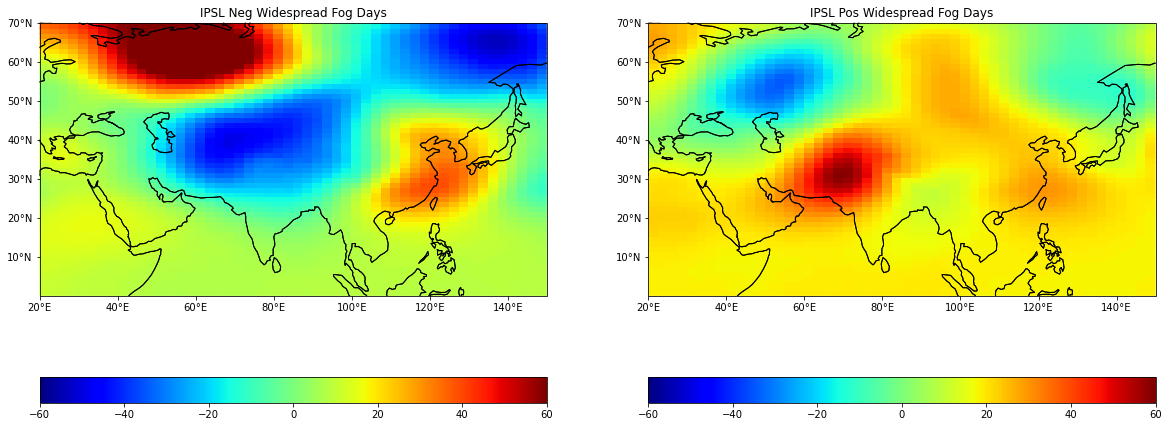

In [80]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.pcolor(zNeg.lon.values,zNeg.lat.values,zNeg,transform=ccrs.PlateCarree(),cmap='jet',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
ax1.set_title('IPSL Neg Widespread Fog Days')
fig.colorbar(m1,orientation='horizontal')

ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())

m2=ax2.pcolor(zPos.lon.values,zPos.lat.values,zPos,transform=ccrs.PlateCarree(),cmap='jet',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax2)
ax2.coastlines()
ax2.set_title('IPSL Pos Widespread Fog Days')

fig.colorbar(m2,orientation='horizontal')

plt.savefig('../IPSLWDF_pos_Neg.jpeg',dpi=300)


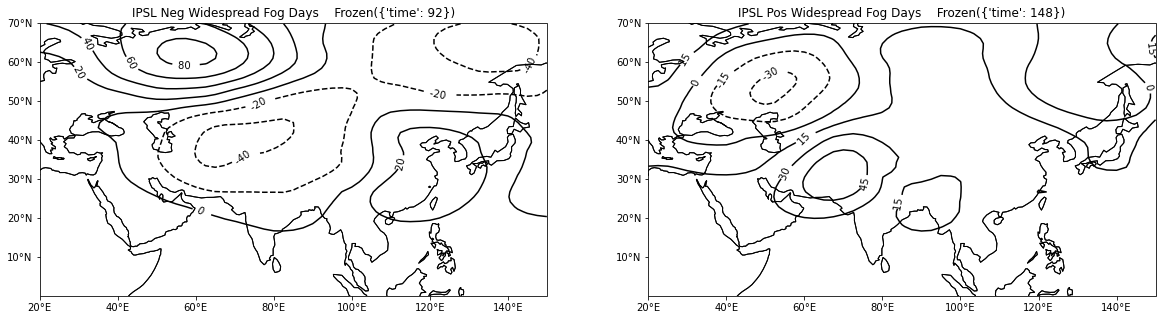

In [81]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contour(zNeg.lon.values,zNeg.lat.values,zNeg,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
# Recast levels to new class
m1.levels = [nf(val) for val in m1.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax1.clabel(m1, m1.levels, inline=True, fmt=fmt, fontsize=10)
ax1.set_title('IPSL Neg Widespread Fog Days'+"    "+str(NegCnt))
#fig.colorbar(m1,orientation='horizontal')


########## second Figure
ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
m2=ax2.contour(zPos.lon.values,zPos.lat.values,zPos,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
map_plot(ax2)
ax2.coastlines()

# Recast levels to new class
m2.levels = [nf(val) for val in m2.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax2.clabel(m2, m2.levels, inline=True, fmt=fmt, fontsize=10)

ax2.set_title('IPSL Pos Widespread Fog Days'+"    "+str(PosCnt))

#fig.colorbar(m2,orientation='horizontal')

plt.savefig('../IPSLWDF_pos_Neg.jpeg',dpi=300)


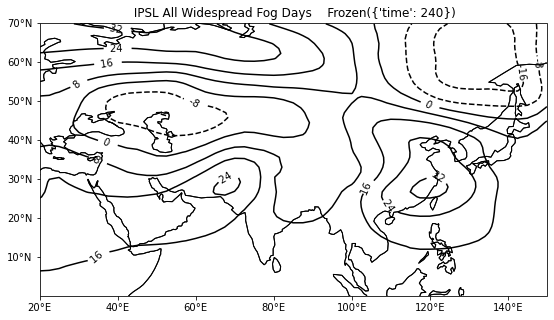

In [82]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contour(zwideAll.lon.values,zwideAll.lat.values,zwideAll,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
# Recast levels to new class
m1.levels = [nf(val) for val in m1.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax1.clabel(m1, m1.levels, inline=True, fmt=fmt, fontsize=10)
ax1.set_title(' IPSL All Widespread Fog Days'+"    "+str(totalCnt) )
#fig.colorbar(m1,orientation='horizontal')
plt.savefig('../IPSLWDF_All.jpeg',dpi=300)